In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from scipy.stats import norm, bernoulli
import json
import warnings; warnings.simplefilter('ignore')
from tqdm.auto import tqdm
from plot_utils import make_width_coverage_plot, get_data, transform_features, make_length_table, make_coverage_table, make_error_table
from baselines import classical_ols_ci
from ppi import ppi_ols_ci
from reppi import ppi_opt_ols_ci_crossfit

In [2]:
np.random.seed(1)

In [3]:
data = pd.read_csv('../text_data/Polite_data.csv')
data = data.sample(frac=1).reset_index(drop=True) # shuffle data
data = data.dropna()
Yhat = data["gpt_score"].to_numpy()
device = 'hedge' # 'hedge' or '1pp'
Y = data["Normalized Score"].to_numpy()
n = len(Y)
if device == 'hedge':
    X_device = data.to_numpy()[:,[4]]
elif device == '1pp':
    X_device = data.to_numpy()[:,[11]]
X = np.column_stack((X_device, np.ones(n))).astype(float)



In [4]:
print(data)

      Unnamed: 0.1  Unnamed: 0  Feature_1  Feature_2  Feature_3  Feature_4  \
0             4864        4864          0          0          0          0   
1             2409        2409          0          0          1          0   
2             1232        1232          0          0          1          0   
3             3188        3188          0          0          0          0   
4             2396        2396          0          0          0          0   
...            ...         ...        ...        ...        ...        ...   
5510           903         903          0          0          0          0   
5511          5156        5156          0          0          0          0   
5512          3950        3950          0          0          0          0   
5513           236         236          0          0          0          0   
5514          5120        5120          0          0          1          0   

      Feature_5  Feature_6  Feature_7  Feature_8  ...  Score3  

In [5]:
print(np.linalg.inv(X.T@X/5479))

[[ 4.82850753 -1.3998467 ]
 [-1.3998467   1.3998467 ]]


In [6]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=False)
result = model.fit(X, Y)
target_index = 0
theta_true = result.coef_[target_index]


In [7]:
num_trials = 50
alpha = 0.1
labeled_fracs = np.linspace(0.10,0.30,30)
n_all = Y.shape[0]

In [8]:
results = []
columns = ["lb", "ub", "interval width", "coverage", "estimator", "n", "mse"]
temp_df = pd.DataFrame(np.zeros((4,len(columns))), columns=columns)
error = np.zeros(4)

for j in tqdm(range(len(labeled_fracs))):
    n = int(labeled_fracs[j]*n_all)
    
    for i in tqdm(range(num_trials)):   
        labeled = np.random.choice(range(n_all), n, replace=False)
        unlabeled = list(set(range(n_all)) - set(labeled))
        X_lab = X[labeled]
        Y_lab = Y[labeled]
        Yhat_lab = Yhat[labeled]
        X_unlab = X[unlabeled]
        Yhat_unlab = Yhat[unlabeled]
        
        
        l, u = classical_ols_ci(X_lab, Y_lab, alpha=alpha)
        coverage = int((theta_true >= l[target_index])*(theta_true <= u[target_index]))
        mse = np.abs(l[target_index]+u[target_index]-2*theta_true)/2
        temp_df.loc[0] = l[target_index], u[target_index], (u[target_index] - l[target_index]), coverage, "XY-only", n, mse
        error[0] += mse

        l, u = ppi_ols_ci(X_lab, Y_lab, Yhat_lab, X_unlab, Yhat_unlab, alpha=alpha, lhat=1)
        coverage = int((theta_true >= l[target_index])*(theta_true <= u[target_index]))
        mse = np.abs(l[target_index]+u[target_index]-2*theta_true)/2
        temp_df.loc[1] = l[target_index], u[target_index], (u[target_index] - l[target_index]), coverage, "PPI", n, mse
        error[1] += mse

        l, u = ppi_ols_ci(X_lab, Y_lab, Yhat_lab, X_unlab, Yhat_unlab, alpha=alpha)
        coverage = int((theta_true >= l[target_index])*(theta_true <= u[target_index]))
        mse = np.abs(l[target_index]+u[target_index]-2*theta_true)/2
        temp_df.loc[2] = l[target_index], u[target_index], (u[target_index] - l[target_index]), coverage, "PPI++", n, mse
        error[2] += mse
        
        l, u = ppi_opt_ols_ci_crossfit(X_lab, Y_lab, Yhat_lab, X_unlab, Yhat_unlab, alpha=alpha, method='linreg')
        coverage = int((theta_true >= l[target_index])*(theta_true <= u[target_index]))
        mse = np.abs(l[target_index]+u[target_index]-2*theta_true)/2
        temp_df.loc[3] = l[target_index], u[target_index], (u[target_index] - l[target_index]), coverage, "RePPI", n, mse
        error[3] += mse

        results += [temp_df.copy()]
df = pd.concat(results,ignore_index=True)

100%|██████████| 30/30 [01:10<00:00,  2.35s/it]


In [9]:
df['labeled ratio'] = round(df['n'] / n_all, 2)

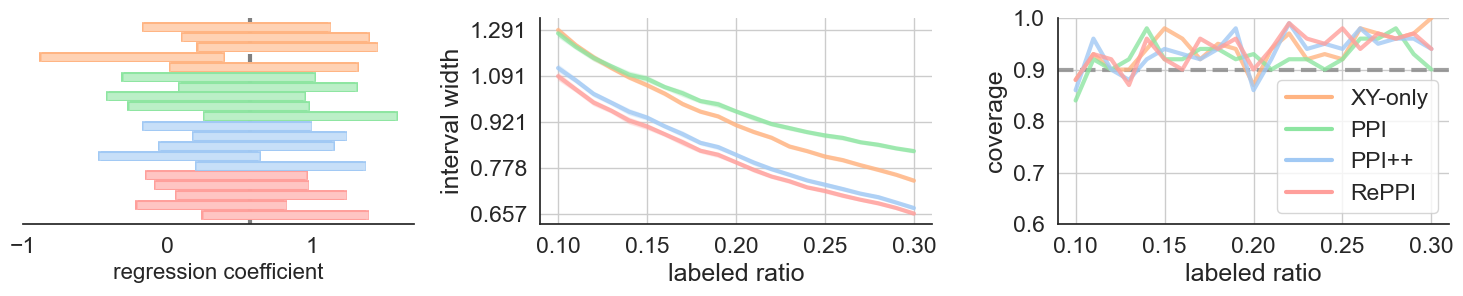

In [10]:
make_width_coverage_plot(df, "regression coefficient", "../results/politeness.pdf", theta_true, num_trials = num_trials, n_example_ind = 0)

In [11]:
df_width = make_length_table(df)
print(df_width)

     XY-only       PPI     PPI++     RePPI       n
0   1.291002  1.275707  1.122729  1.089549   551.0
1   1.242062  1.234476  1.091402  1.057480   589.0
2   1.200659  1.193184  1.054345  1.017845   627.0
3   1.167425  1.164955  1.020688  0.988814   665.0
4   1.135912  1.139467  0.998280  0.968981   703.0
5   1.110460  1.119597  0.978110  0.949850   741.0
6   1.084574  1.095246  0.955844  0.925359   779.0
7   1.054207  1.079068  0.935598  0.905432   817.0
8   1.034160  1.056942  0.915241  0.889335   855.0
9   1.009435  1.036667  0.896977  0.870886   893.0
10  0.983673  1.023101  0.880576  0.854382   931.0
11  0.966399  1.001309  0.859962  0.834516   969.0
12  0.946750  0.988017  0.845638  0.822258  1007.0
13  0.939799  0.982500  0.839426  0.815901  1045.0
14  0.917112  0.962993  0.822396  0.800580  1083.0
15  0.903317  0.951738  0.809811  0.786756  1121.0
16  0.887504  0.934918  0.793014  0.771947  1159.0
17  0.874371  0.916963  0.777867  0.757365  1197.0
18  0.863347  0.910608  0.77010

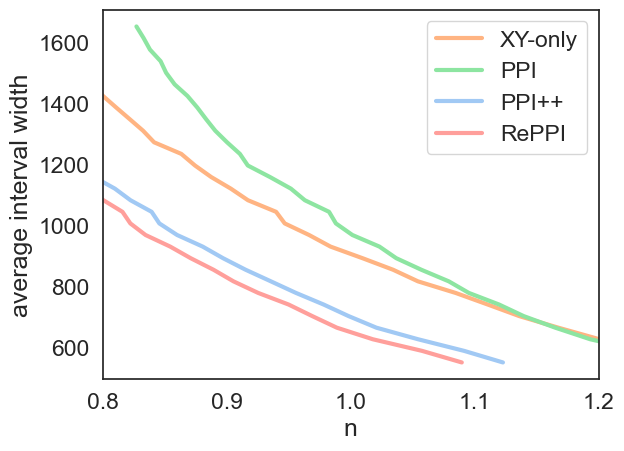

In [12]:
import matplotlib.pyplot as plt
for method in ["XY-only", "PPI", "PPI++", "RePPI"]:
    plt.plot(df_width[method], df_width['n'], label=method)
plt.ylabel('average interval width')
plt.xlim(0.8, 1.2)
plt.xlabel('n')
plt.legend()

In [13]:
n_value = [0.7, 0.8, 0.9, 1.0, 1.1]
interpolated_values = {}
for method in ["XY-only", "PPI", "PPI++", "RePPI"]:
    interpolated_values[method] = np.interp(n_value, df_width[method][::-1], df_width['n'][::-1])
print(interpolated_values)

{'XY-only': array([1653.        , 1426.16065425, 1128.97073559,  906.91683572,
        756.35498752]), 'PPI': array([1653.        , 1653.        , 1274.00959045,  972.7427731 ,
        771.58116339]), 'PPI++': array([1524.39576043, 1143.19545842,  886.70935447,  700.08339764,
        578.57034167]), 'RePPI': array([1438.14858555, 1084.59453352,  829.82422409,  650.3583379 ,
        551.        ])}
